<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Декомпозиция" data-toc-modified-id="Декомпозиция-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Декомпозиция</a></span></li><li><span><a href="#Создание-новых-признаков" data-toc-modified-id="Создание-новых-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание новых признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Выборки" data-toc-modified-id="Выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выборки</a></span></li><li><span><a href="#Нормализация-признаков" data-toc-modified-id="Нормализация-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Нормализация признаков</a></span></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Ridge Regression</a></span></li><li><span><a href="#GradientBoostingRegressor" data-toc-modified-id="GradientBoostingRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>GradientBoostingRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error



### Знакомство с данными

In [2]:
data = pd.read_csv('/datasets/taxi.csv',   # путь к файлу
               index_col=[0],   # столбец, который будет индексом
               parse_dates=[0])  # столбец, который надо перевести в формат даты

In [3]:
data.shape

(26496, 1)

In [4]:
data.head()


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Ресемплирование

In [5]:
data = data.resample('h').sum()                       # ресемплирование данных

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
data.shape

(4416, 1)

## Анализ

In [8]:
data.index.is_monotonic # проверили, что дата возрастает без неожиданных скачков назад в прошлое

True

### Декомпозиция

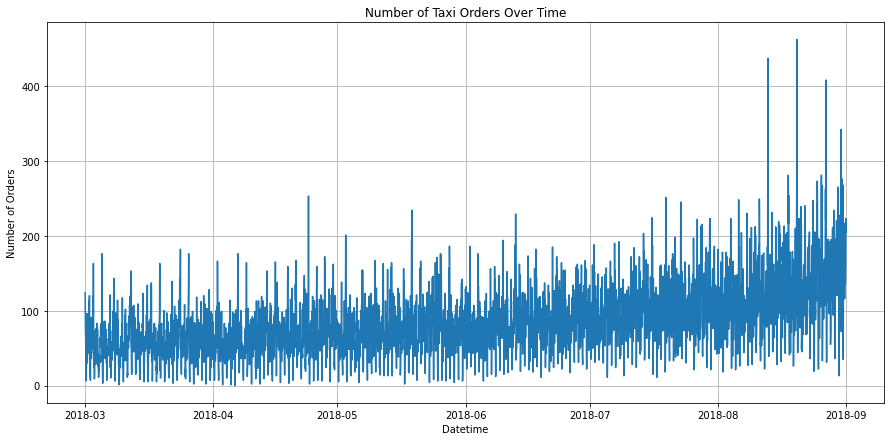

In [9]:
# Plot the data
plt.figure(figsize=(15,7))
plt.plot(data.index, data['num_orders'])
plt.title('Number of Taxi Orders Over Time')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

Видим, что число заказов со временем постепенно возрастает (тренд), но при этом также заметны определенные колебания (подозреваем сезонность-цикличность).

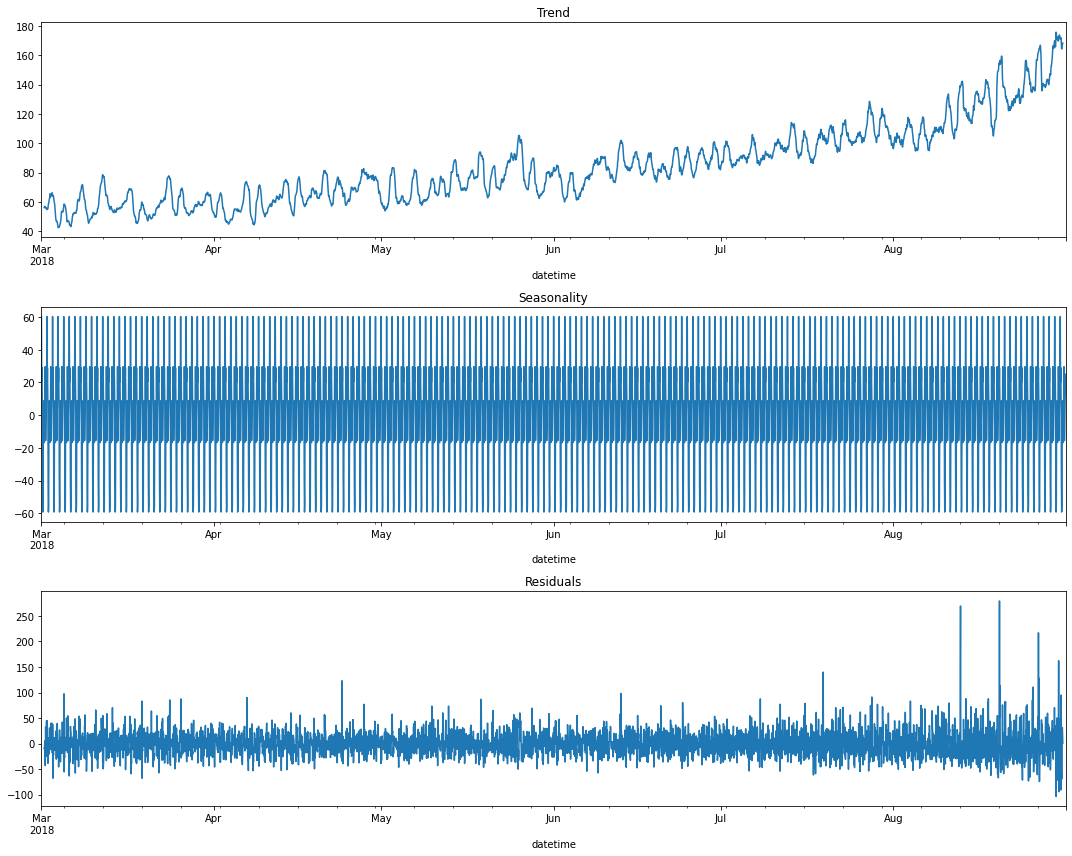

In [10]:
# Decompose the time series
decomposed = seasonal_decompose(data) 

# Plot the decomposed time series
plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

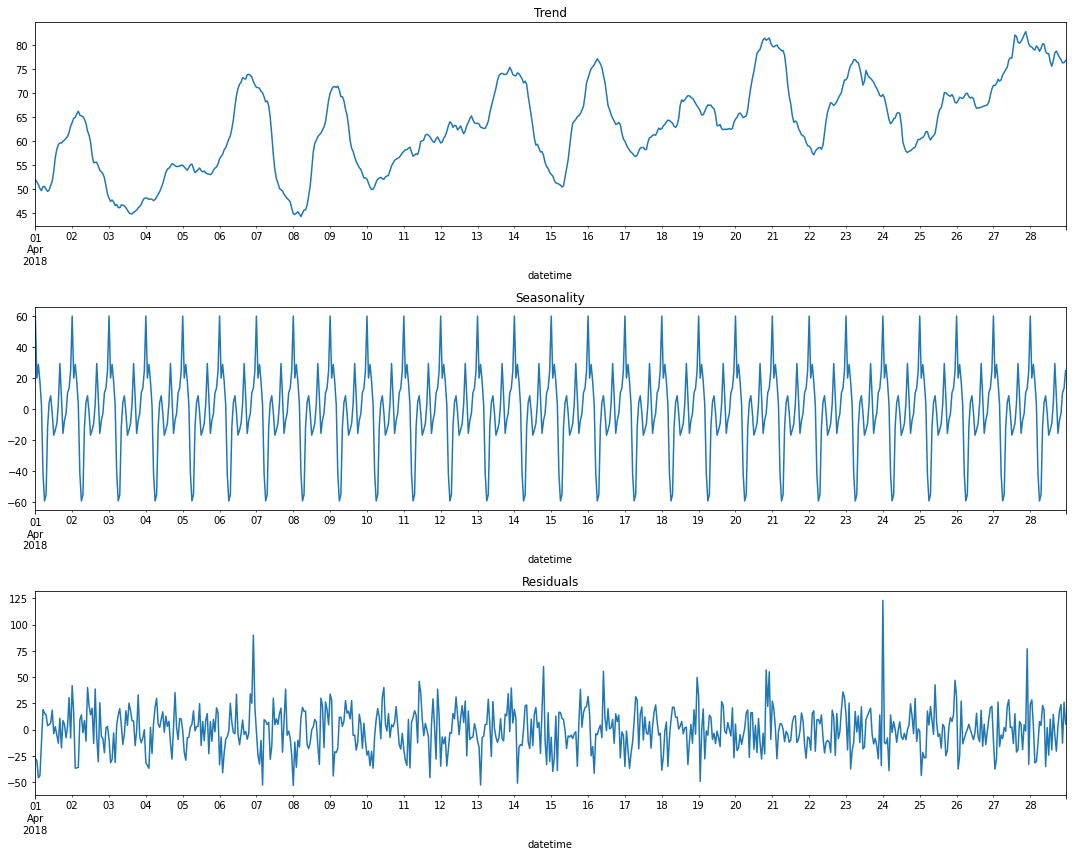

In [11]:
plt.figure(figsize=(15, 12))

_from = '2018-04-01'
_to = '2018-04-28'

plt.subplot(311)
decomposed.trend[_from:_to].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal[_from:_to].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid[_from:_to].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

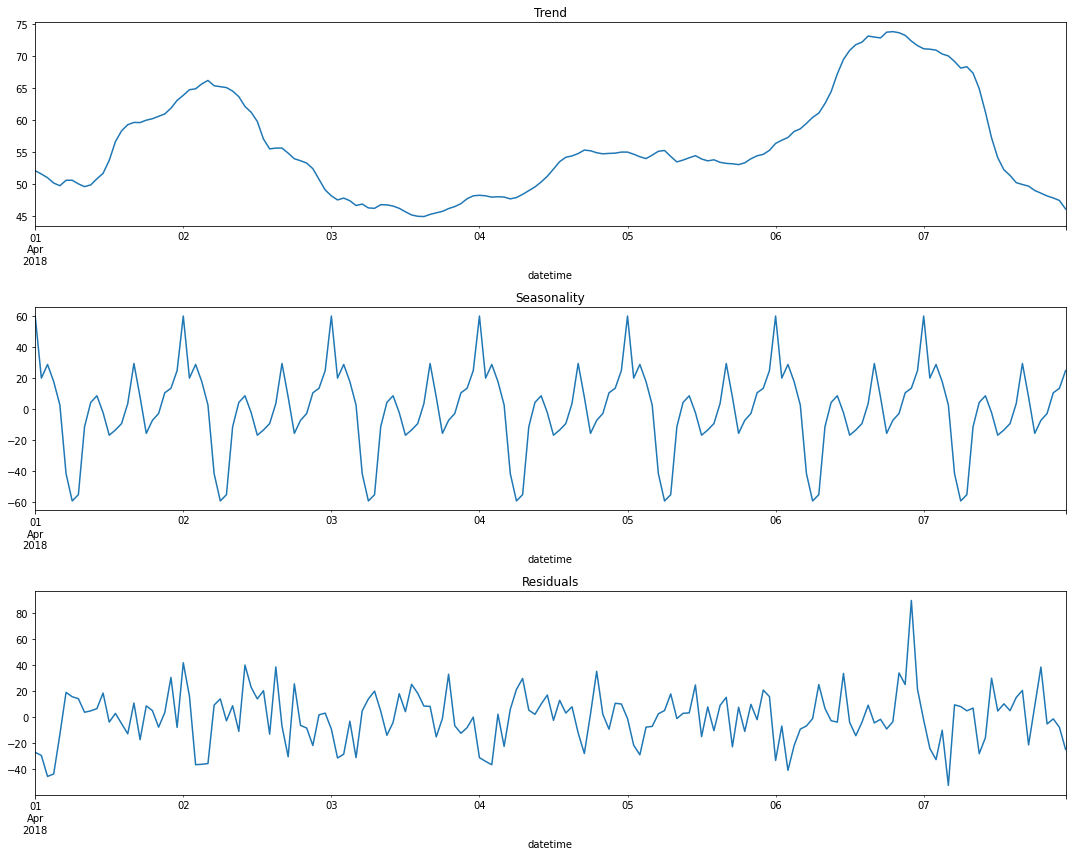

In [12]:
plt.figure(figsize=(15, 12))

_from = '2018-04-01'
_to = '2018-04-07'

plt.subplot(311)
decomposed.trend[_from:_to].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal[_from:_to].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid[_from:_to].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

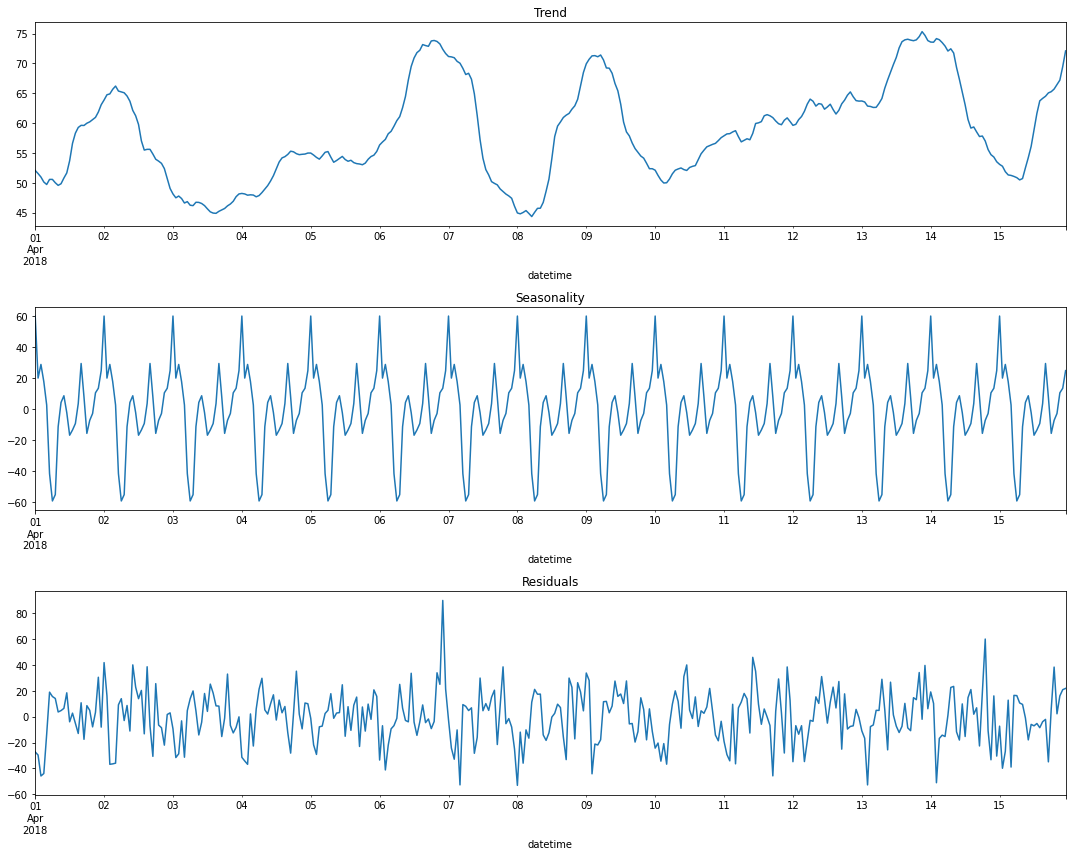

In [13]:
plt.figure(figsize=(15, 12))

_from = '2018-04-01'
_to = '2018-04-15'

plt.subplot(311)
decomposed.trend[_from:_to].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal[_from:_to].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid[_from:_to].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Разложили график на тренд, сезонность и шум.

ТРЕНД: 
в данных прослеживается четкая тенденция к росту, указывающая на то, что количество заказов со временем увеличивалось.

СЕЗОННОСТЬ: 
существует ежедневная закономерность сезонности. Картина повторяется каждые 24 часа. Во многом это связано с ежедневным циклом человеческой деятельности (например, люди склонны заказывать такси в определенное время суток чаще, чем другие).

ШУМ: 
остатки (т.е. та часть временного ряда, которая не объясняется трендом и сезонностью) показывают некоторые закономерности. Это не чистый шум, указывающий на то, что могут действовать и другие факторы, которые не учитываются трендом и сезонностью.

### Создание новых признаков

Добавим календарные признаки, лаги и скользящие средние с разным форматом окна.

In [14]:
# Adding calendar features
data['hour'] = data.index.hour
# data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
# data['month'] = data.index.month
# data['year'] = data.index.year

In [15]:
data.head()

,num_orders,hour,dayofweek
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,4,3


In [16]:
# Adding lag features
for lag in range(1, 25):
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)


In [17]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Adding rolling mean features
for window in [3, 6, 12, 24]:
    data[f'rolling_mean_{window}'] = data['num_orders'].shift().rolling(window).mean()


In [19]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_3,rolling_mean_6,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,93.333333,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,74.000000,NaN,NaN,NaN


In [20]:
# Drop the first 24 rows which have NaN values due to lag features
data = data.dropna()

In [21]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_3,rolling_mean_6,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,6.0,43.0,66.0,71.0,85.0,124.0,79.000000,69.333333,56.583333,56.833333
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,12.0,6.0,43.0,66.0,71.0,85.0,87.000000,72.166667,61.583333,55.416667
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,15.0,12.0,6.0,43.0,66.0,71.0,89.333333,84.666667,68.916667,56.875000
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,95.000000,87.000000,71.166667,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,86.333333,86.666667,71.000000,56.958333


## Обучение

### Выборки

In [22]:
# Split the data into features (X) and target (y)
X = data.drop('num_orders', axis=1)
y = data['num_orders']

In [23]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42, shuffle=False)

In [24]:
X_train_temp.shape, X_test.shape, y_train_temp.shape, y_test.shape

((3952, 30), (440, 30), (3952,), (440,))

In [25]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3556, 30), (396, 30), (3556,), (396,))

### Нормализация признаков

In [26]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)


X_train_scaled.shape, X_valid_scaled.shape, X_test_scaled.shape

((3556, 30), (396, 30), (440, 30))

### Ridge Regression

In [27]:
# List of alphas to check
alphas = [0.1, 1.0, 2.0, 10.0]  # это лмбды, коэффициенты для минимизации весов, будем перебирать этот гиперпараметр

# Initialize a dictionary to store the RMSE for each alpha
rmse_scores = {}  # посмотрим на ошибку для регрессий с разным гиперпараметром

# For each alpha
for alpha in alphas:
    # Initialize and train the Ridge Regression model
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Predict on the valid data
    valid_preds = model.predict(X_valid_scaled)
    
    # Calculate RMSE on the valid data
    valid_rmse = sqrt(mean_squared_error(y_valid, valid_preds))
    
    # Store the RMSE in the dictionary
    rmse_scores[alpha] = valid_rmse

rmse_scores

{0.1: 34.36138027703726,
 1.0: 34.361518933380424,
 2.0: 34.361675216946274,
 10.0: 34.363008588037516}

Хм, почему-то регуляризация весов роли не играет, разница буквально в сотых долях.

### GradientBoostingRegressor

In [28]:
# List of learning rates to check
learning_rates = [0.1, 0.5, 1.0]

# Initialize a dictionary to store the RMSE for each learning rate
rmse_scores_gb = {}

# For each learning rate
for lr in learning_rates:
    # Initialize and train the Gradient Boosting Regressor
    model_gb = GradientBoostingRegressor(learning_rate=lr, random_state=42)
    model_gb.fit(X_train_scaled, y_train)
    
    # Predict on the valid data
    valid_preds_gb = model_gb.predict(X_valid_scaled)
    
    # Calculate RMSE on the valid data
    valid_rmse_gb = sqrt(mean_squared_error(y_valid, valid_preds_gb))
    
    # Store the RMSE in the dictionary
    rmse_scores_gb[lr] = valid_rmse_gb

rmse_scores_gb

{0.1: 32.34220042656767, 0.5: 36.58592454086951, 1.0: 50.23702057525045}

### RandomForestRegressor

In [29]:
# Initialize and train the Random Forest Regressor
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Predict on the valid data
valid_preds_rf = model_rf.predict(X_valid_scaled)

# Calculate RMSE on the valid data
valid_rmse_rf = sqrt(mean_squared_error(y_valid, valid_preds_rf))

valid_rmse_rf

32.084410835900805

Штош, героическая борьба за лишний процентик точности неожиданно привела нас к случайному лесу. Ладно.

## Тестирование

Валидационная выборка нам больше не нужна, объединим её с обучающей выборкой, ибо больше тренировочной выборки богу тренировочной выборки!


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

42.58718574076223

Мы проверили разные модели - линейную регрессию, бустинг и случайный лес. В линейной регрессии параметр регуляризации не оказал влияния на предсказания (непонятно, почему). В бустинге прошлись по нескольким гиперпараметрам и получили неплохое качество на валидации. Однако, оказалось, что если для сравнения запустить случайный лес с дефолтными параметрами, он на валидации показывает результаты ещё лучше. Поэтому выбрали его в качестве финальной модели. На тесте он показал приемлемый результат: RMSE=42 (по задаче требовалось не более 48).